# Comparison of YOLO1, YOLO2, and YOLO3

# YOLO1

### 1.The main ideas of target detection

Unlike the RCNN series, YOLO treats target detection as a regression problem, and directly uses a network for classification and box regression.

The specific method is: divide the image into S * S grids, and each grid predicts the positions (x, y, w, h) of B bboxes, confidence (confidence is the intersection ratio), and class probability. The output dimension is S * S * (B * 5 + C), and C is the number of categories. No matter how many boxes are contained in the grid, each grid only predicts a set of class probabilities. During the test, the conditional class probability and the confidence of the prediction box are multiplied to indicate that each box contains the confidence of a certain type of object. This score can represent the category probability and prediction accuracy of the box at the same time.


### 2. Overall network structure

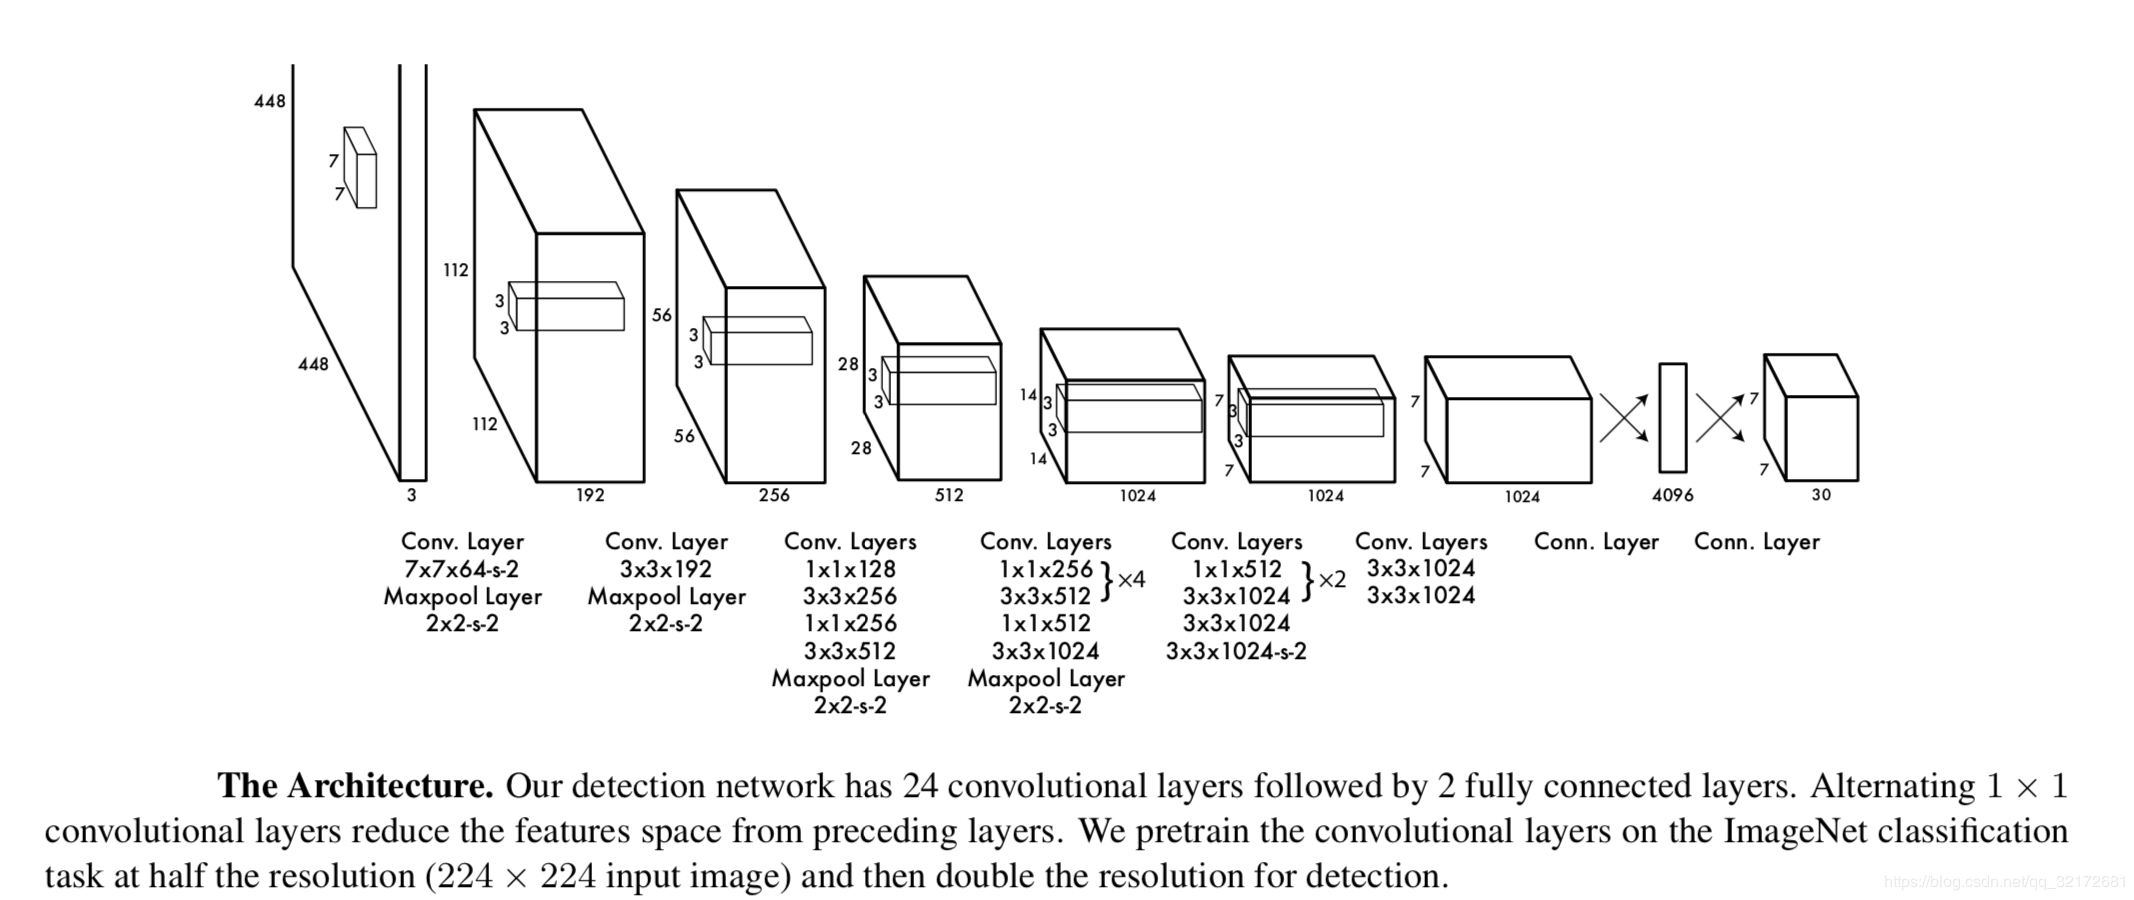

The basic network model is GoogLe Net, but instead of using its inception module, it uses 1 * 1 and 3 * 3 convolutional layers alternately.

Convolutional layer extraction features, fully connected layer prediction category and box position regression, a total of 24 convolutional layers, 2 fully connected layers.

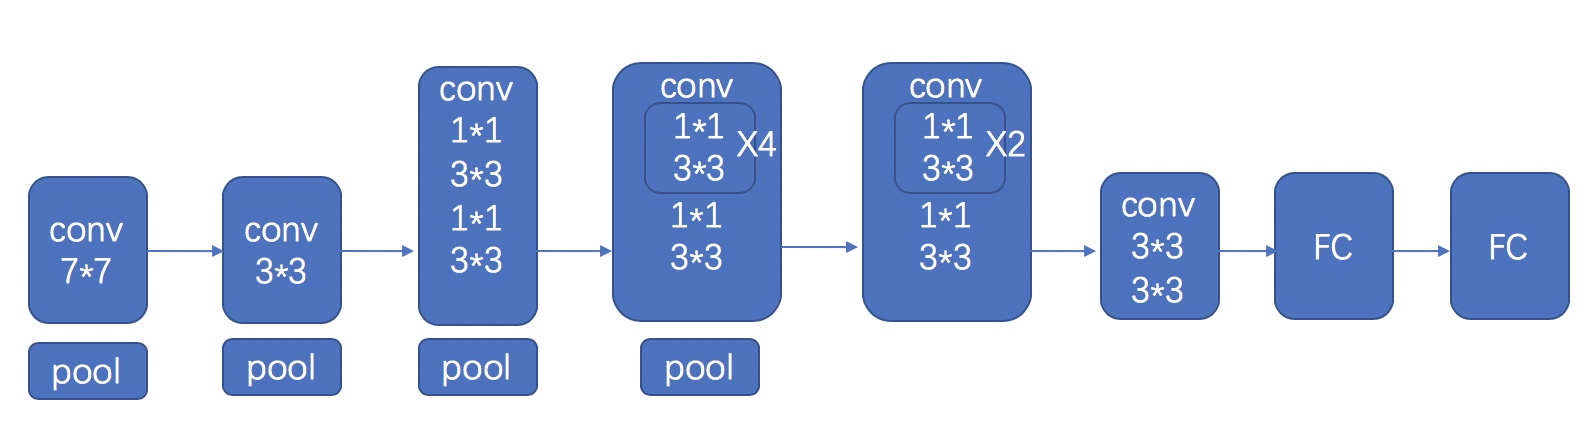
                                
                                24-Convolutional + 2 fully connected layers

### 3. Sub-network: pre-trained classification network, the input image size is 224 * 224
First 20 convolutional layers + 1 global average pooling + 1 fully connected

### 4. Sub-network: target detection network, the input image size is 448 * 448

First 20 convolutional layers + 4 convolutional layers + 2 fully connected + 1 fully connected (prediction category / frame position)

### 5. Loss function (square sum loss function)

Including 4 parts: box center position x, y loss + box width and height w, h loss + confidence loss + classification loss.
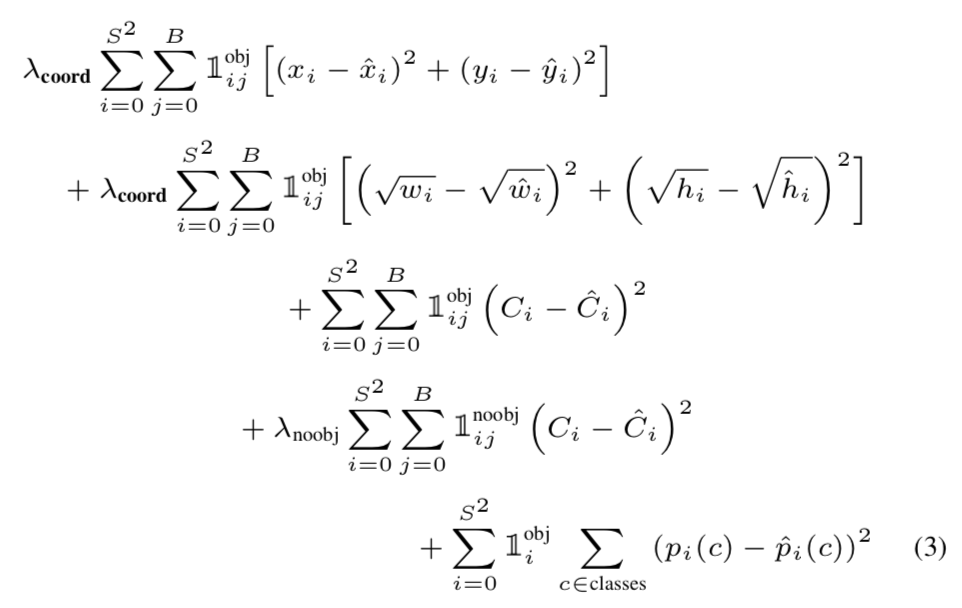


### 6. YOLO1 advantages:

* High speed. Seen as a regression problem, no complicated pipeline is needed.
* Have a global understanding of the image. Use the features of the entire image to predict the bbox, instead of RCNN, only the   features of the candidate box can be used to predict the bbox.
* The number of candidate boxes is much smaller, only 7 * 7 * 2 = 49. The RCNN has 2000 selectlive searches, which are       computationally intensive.

### 7. YOLO1 disadvantages:

* Each grid only predicts 2 bboxes, which limits the number of objects predicted by the model.
* After multiple downsampling, the features used for bounding box prediction are relatively coarse features.

# YOLO2

### 1. Improvement 1: detect more kinds of targets

Using the large classification data set ImageNet to expand the data types of target detection, it can detect 9,000 types of targets (YOLO1 only has 20 types)


### 2. Improvement 2: Batch standardized BN

Make the gradient larger and avoid the gradient disappearing
Faster convergence and faster training
Not applied to the entire data set, noisy, improving the generalization ability of the model

### 3. Improvement 3: Train the classification network with high-resolution images

The input image size of the YOLO1 classification network is 224 * 224, and the input image size of the target detection network is 448 * 448. Therefore, YOLO1 needs to complete both the target detection task and the task of adapting to higher resolution images.

### 4. Improvement 4: borrow RPN anchor boxes, have prior knowledge, and make prediction faster.

### 5. Improvement 5: Use k-mean clustering algorithm to get the prior box piror boxes of YOLO2

Use the k-mean clustering algorithm to let the model automatically select the more appropriate a priori frame length and width (YOLO1 is manually specified, with a certain degree of subjectivity)

Distance matrix of the custom clustering algorithm:, centroid is the box selected as the cluster center during clustering, and box is the other box.

### 6. Improvement 6: The predicted offset is limited to a grid range, and the model is more stable.

The prediction is the offset of the center of the prediction box relative to the grid unit. The logistic is used to limit the prediction value to a range of 0-1, so that the box offset will not exceed 1 network (RPN prediction anchor box and prediction box bbox. Offset, it is possible that the offset is large, causing the model to be unstable)

### 7. The grid predicts 5 offsets for each bbox: tx, ty, tw, th, to

Let the distance from the upper left corner of the grid to the upper left corner of the image be cx, cy, and the height and width of the piror bounding (template box) be ph and pw.

The calculation of the prediction frame coordinates is shown in the figure:

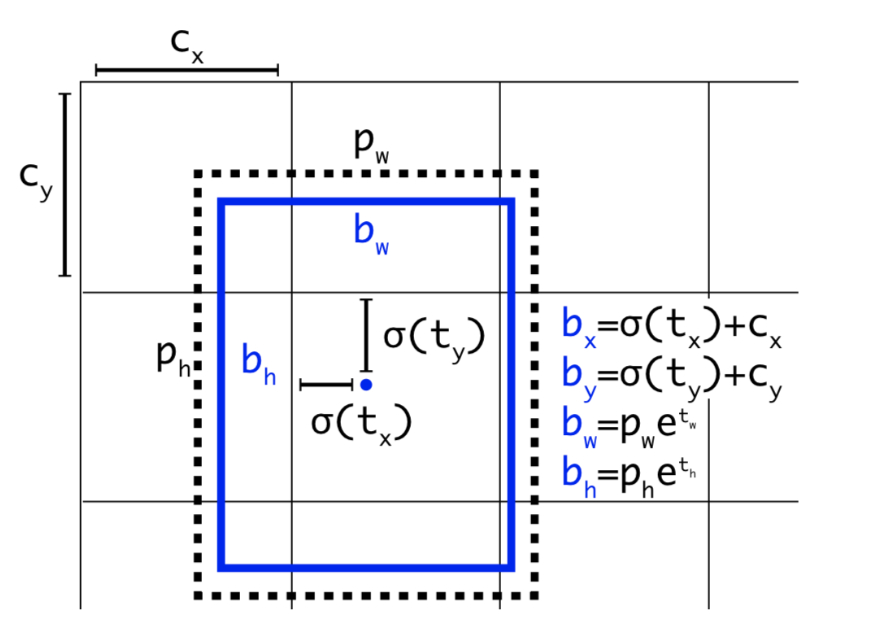

### 8. Improvement 7: The passthrough layer is proposed, which is good for small target detection.

The 26 * 26 * 512 feature map of the previous layer is divided into four, which are connected into four 13 * 13 * 2048 feature maps, and then connected with the 13 * 13 * 1024 feature map of the subsequent layer to obtain 13 * 13 * 3072 features Illustration.

### 9. Improvement 8: Multi-scale input images for training

    FCN network, not fixed input size

### 10. Classification network model (YOLO2's own model): Darknet-19

Similar to vgg, in the end, global average pooling is used, each feature map gets 1 value, and then using full connection will have many fewer parameters.

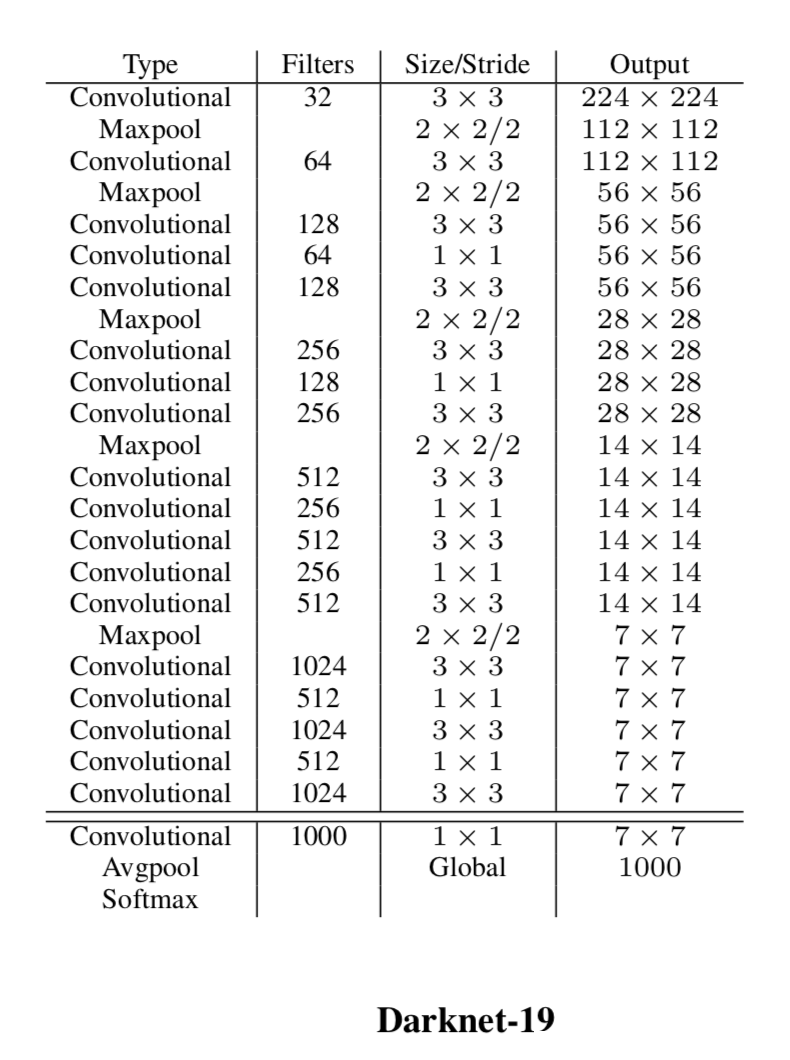

Darknet19 : 19 convolutional layers +  5 pooling layers, the last global average pooling layer outputs 1000 categories (without using a fully connected layer).

<img src = "Darknet19CLand5PL.png">

                       Darknet19 : 19 convolutional layers +  5 pooling layers

                        

### 11.Target detection network model

Remove the last 1000 class output convolutional layers of the classification network, plus 3 3 * 3 convolutional layers, each 1 * 1 convolutional layer after each 3 * 3, and the last 3 * 3 * 512 Add a passthrough layer between the second and the penultimate 3 * 3 * 1024 to get more detailed results, and the last 1 * 1 layer outputs the result. The network structure diagram is omitted. (It looks like 11 new floors are added here)

### 12. Hybrid classification and detection data sets, joint training classification, detection network

YOLO2 proposes a joint training mechanism that mixes images from detection and classification datasets for training. When the network sees the image marked for detection, it back-propagates based on the full yolov2 loss function. When it sees a classified image, it only back-propagates the loss from the classification-specific part.

# YOLO3

### 1. Multi-label detection

There may be multiple categories of objects in each box, and softmax can only be used for single classification, so instead of sigmoid, sigmoid can be used for multi-label classification.

### 2. Combine the characteristics of different convolutional layers to make multi-scale predictions

The feature map sampled on the current layer is added to the feature map of the upper layer to obtain a combined feature map, and some convolutional layers are added to process the combined feature map, so that a more fine-grained target can be predicted.

### 3. Network structure (DarkNet53 = DarkNet19 + ResNet)

* Combine the residual thought to extract deeper semantic information.
* Continuous 3 × 3 and 1 × 1 convolutional layers are still used.
* Prediction is performed on three different scales by upsampling. For example, the 8 * 8 feature map upsampling and the 16 * 16 feature map are added and calculated again, so that smaller objects can be predicted.
* A convolutional layer with a step size of 2 is used instead of the pooling layer because the pooling layer will lose information.

<img src = "networkStructure1.png">

<img src = "networkStructure2.png">

### 4. Predict more goals

Use k-mean mean clustering algorithm to predict 9 template boxes for each grid, so that the recall can be improved (5 in YOLO2 and 2 in YOLO1).

### 5. Loss function

Class prediction using cross-entropy loss function (square error for YOLO2).